In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import shutil
import json
import pickle
from tqdm import tqdm
import random
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from PIL import Image

from load_model import load_model
from load_model_barlowtwins import load_barlowtwins_model

from rn50_auxiliary_dm import rn50_auxiliary_dm

import scipy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import svm

from scipy.stats import spearmanr
from scipy.io import loadmat

from torchvision import transforms
from scipy.spatial.distance import pdist, squareform

Using cache found in /home/sl5700/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/sl5700/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/sl5700/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Experiment list summarized

# Basic GFR/CTFR/GOR tasks 
exp_names_list_basics = [
    # 1. (Josh) Apple GFR - Elias/Neptune neutral
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/vbsl_151/20211011_Var6vbsl_set0_im151_elias',
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/vbsl_151/20211011_Var6vbsl_set0_im151_neptune',

    # 2. (Seojin) Apple GFR - Elias/Neptune neutral
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_neptune/vbsle151_neptune_neutral',

    # 3. (Josh) Apple GFR - Sophie/Praneeth
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/ood/vbsl151_sophie_praneeth/20230406_Var6vbsl_set0_im151_praneeth_dur200ms_lab',
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/ood/vbsl151_sophie_praneeth/20230406_Var6vbsl_set0_im151_sophie_dur200ms_lab',

    # 4. (Josh) Basel CTFR 
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/ood/vbsl151_basel_ood/20230406_Var6vbsl_set0_im151_Baselmesh_ood_0_dur200ms_lab',
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/ood/vbsl151_basel_ood/20230406_Var6vbsl_set0_im151_Baselmesh_ood_1_dur200ms_lab',

    # 5. (Josh) Basel GFR
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/ood/vbsl151_basel_ood_notexture/20230406_Var6vbsl_set0_im151_Baselmesh_ood_0_notexture_dur200ms_lab',
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/ood/vbsl151_basel_ood_notexture/20230406_Var6vbsl_set0_im151_Baselmesh_ood_1_notexture_dur200ms_lab',
]

# complete GFR
exp_names_list_GFR = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_neptune/vbsle151_neptune_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_seojin/vbsle151_seojin_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_dan/vbsle151_dan_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sreyas/vbsle151_sreyas_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_younah/vbsle151_younah_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_ashley/vbsle151_ashley_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_kedar/vbsle151_kedar_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_josh/vbsle151_josh_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_ani/vbsle151_ani_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_tony/vbsle151_tony_neutral',
]

# complete CTFR
exp_names_list_CTFR = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_neptune_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_seojin_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_sophie_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_dan_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_sreyas_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_younah_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_ashley_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_kedar_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_josh_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_ani_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_tony_neutral',
]

# complete GTFR 
exp_names_list_GTFR = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_neptune_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_seojin_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_sophie_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_dan_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_sreyas_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_younah_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_ashley_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_kedar_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_josh_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_ani_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_tony_neutral',
]

# complete GER (sophie)
exp_names_list_GER_sophie = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_happiness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_sadness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_disgust_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_fear_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_anger_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_sophie/vbsle151_sophie_surprise_4',
   ]

# complete GER (elias)
exp_names_list_GER_elias  = [ 
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_happiness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_sadness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_disgust_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_fear_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_anger_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_surprise_4',
    ]

# complete CTER (elias)
exp_names_list_CTER_elias = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_happiness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_sadness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_disgust_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_fear_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_anger_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_colorbg/vbsl151_elias_surprise_4',
]

# complete GTER (elias)
exp_names_list_GTER_elias = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_neutral',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_happiness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_sadness_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_disgust_4'
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_fear_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_anger_4',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151_texture_graybg/vbsl151_elias_surprise_4',
]

# complete Basel GFR (id10-21)
exp_names_list_basel_GFR = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id10',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id11',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id12',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id13',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id14',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id15',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id16',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id17',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id18',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id19',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id20',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id21',
]

# complte Basel CTFR (id10-21)
exp_names_list_basel_CTFR = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id10',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id11',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id12',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id13',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id14',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id15',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id16',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id17',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id18',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id19',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id20',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id21',
]

# complete Basel GFR (id988-999)
exp_names_list_basel_GFR_ver2 = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id988',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id989',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id990',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id991',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id992',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id993',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id994',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id995',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id996',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id997',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id998',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_no_texture/Basel_no_texture_test_1000ID/id999',
]

# complte Basel CTFR (id988-999)
exp_names_list_basel_CTFR_ver2 = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id988',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id989',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id990',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id991',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id992',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id993',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id994',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id995',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id996',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id997',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id998',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/Basel_colored_texture/Basel_colored_texture_test_1000ID/id999',
]

# LFW (upright, inverted)
exp_names_list_lfw = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/LFW_Bush_Powell/Bush',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/LFW_Bush_Powell/Powell',

    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/LFW_Bush_Powell_inverted/Bush',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/LFW_Bush_Powell_inverted/Powell',
]

# YouTube Faces
exp_names_list_ytface = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/YoutubeFaces/Stanca',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/YoutubeFaces/Beard',

    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/YoutubeFaces/Kennedy',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/YoutubeFaces/Macdonald',
]

# complete GOR 
exp_names_list_GOR = [
    # 1. (Josh) GOR - Camel/Elephant
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/objs/20211011_Var6vbsl_set0_im151_camel',
    '/mnt/smb/locker/issa-locker/users/Josh/data/face_data/control_exp/objs/20211011_Var6vbsl_set0_im151_elephant',

    # 2. GOR - Dog/Horse 
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_dog_horse/vbsle_151_dog', 
    '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_dog_horse/vbsle_151_horse',

    # 3. GTOR - Camel/Elephant
    '/mnt/smb/locker/issa-locker/users/Seojin/data/object_data/GOR_colored_gray_downsampled/camel_colored_gray',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/object_data/GOR_colored_gray_downsampled/elephant_colored_gray',
    
    # 4. CTOR - Camel/Elephant
    '/mnt/smb/locker/issa-locker/users/Seojin/data/object_data/GOR_colored_downsampled/camel_colored',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/object_data/GOR_colored_downsampled/elephant_colored',
]

# ImageNet-based tasks (general object recognition)
exp_names_list_imagenet = [
    '/mnt/smb/locker/issa-locker/users/Seojin/data/shark151/shark1',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/shark151/shark2',

    '/mnt/smb/locker/issa-locker/users/Seojin/data/bird151/bird1',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/bird151/bird2',
    
    '/mnt/smb/locker/issa-locker/users/Seojin/data/vehicle151/bike',
    '/mnt/smb/locker/issa-locker/users/Seojin/data/vehicle151/car'
]

# Compute RDM

### For one testing set (one face category)

In [2]:
# define models and test set

model_names_list = [
    'resnet50',
    'barlowtwins',
    'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50',
]

exp_names_list = ['/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral',]

In [3]:
filename_postfix = ''
save_label = False

for model_name in model_names_list:
    # flatten & subsample for previous layers of resnet50
    if 'layer' in model_name or "subsampled" in model_name:
        if "layerC2" in model_name and "layerC2_subsampled" not in model_name:
            subsample = False
        else:
            subsample = True
    else:
        subsample = False
    # load model
    model = load_model(model_name)
    model.eval()
    
    # add hook
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    if 'simplecnn' in model_name:
        model.fc2.register_forward_hook(get_activation('feats'))
    elif 'alexnet' in model_name:
        if 'layer4' in model_name:
            print("add hook in layer4")
            model.features[4].register_forward_hook(get_activation('feats'))
        elif 'layer8' in model_name:
            print("add hook in layer8")
            model.features[8].register_forward_hook(get_activation('feats'))
        elif 'layer12' in model_name:
            print("add hook in layer12")
            model.features[12].register_forward_hook(get_activation('feats'))
        elif 'layerC2' in model_name:
            model.classifier[2].register_forward_hook(get_activation('feats'))
        else: # final layer
            model.classifier[5].register_forward_hook(get_activation('feats'))
    elif model_name == 'vgg16':
        model.classifier[4].register_forward_hook(get_activation('feats'))
    elif model_name == 'vggface':
        model.fc7.register_forward_hook(get_activation('feats'))
    elif 'onlyDM' in model_name:
        model.depth_predictor.encoder[4].register_forward_hook(get_activation('feats'))
    else: # resnet50
        if 'layer1' in model_name:
            print("add hook in layer1")
            model.layer1.register_forward_hook(get_activation('feats'))
        elif 'layer2' in model_name:
            print("add hook in layer2")
            model.layer2.register_forward_hook(get_activation('feats'))
        elif 'layer3' in model_name:
            print("add hook in layer3")
            model.layer3.register_forward_hook(get_activation('feats'))
        elif 'layer4_no_pooling' in model_name:
            print("add hook in layer4_no_pooling")
            model.layer4.register_forward_hook(get_activation('feats'))
        else:
            model.avgpool.register_forward_hook(get_activation('feats'))
        
    # load data
    for exp_index, exp_name in enumerate(exp_names_list):
        print(model_name, exp_name)
        valdir = exp_name
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        _trans = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

        ## read & sort img filenames
        all_filenames = []
        # read img filenames
        for filename in os.listdir(valdir):
            if filename[-4:]=='.png':
                all_filenames.append(filename)
        print(len(all_filenames))
        
        # extract feats
        FEATS = []
        LABELS = []
        # loop through batches
        for idx, filename in enumerate(all_filenames):
            # read & transform img
            img = Image.open(os.path.join(valdir, filename)).convert("RGB")
            img_trans = _trans(img)
            # move to device
            inputs = img_trans.unsqueeze(0).cuda()
            # forward pass [with feature extraction]
            preds = model(inputs)
            # add feats and preds to lists
            FEATS.append(activation['feats'].cpu().squeeze().unsqueeze(0).numpy())
            if save_label:
                LABELS.append(outputs.cpu().squeeze().unsqueeze(0).numpy())
        FEATS = np.concatenate(FEATS, axis=0)
        if save_label:
            LABELS = np.concatenate(LABELS, axis=0)
        print(FEATS.shape)
        
        if subsample:
            FEATS = FEATS.reshape([FEATS.shape[0], -1])
            if exp_index == 0: # use the same subset indexes for all exp
                # sampled_indexes = np.random.permutation()
                # sampled_indexes = np.random.permutation(FEATS.shape[1])[:2048]
                sampled_indexes = np.random.choice(FEATS.shape[1], 2048, replace=False)
            FEATS = FEATS[:, sampled_indexes]
            print(f"subsample to 2048 feats, {FEATS.shape}")
        
        # Step 1: Calculate the RDM using correlation distance
        correlation_distances = 1 - (np.corrcoef(FEATS))

        print("RDM min:", np.min(correlation_distances))
        print("RDM max:", np.max(correlation_distances))

        # Step 2: Save the RDM matrix
        rdm_filename = exp_name + '_' + model_name + '_rdm.npy'
        np.save(rdm_filename, correlation_distances)
        print(f'Saving RDM to {rdm_filename}\n')

loading resnet50
1
2


/home/sl5700/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/sl5700/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50 /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral
151
(151, 2048)
RDM min: 0.0
RDM max: 0.9519143326559864
Saving RDM to /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral_resnet50_rdm.npy

loading barlowtwins
1


/home/sl5700/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/sl5700/.cache/torch/hub/facebookresearch_barlowtwins_main


Loaded pretrained Barlow Twins backbone.
Replaced final fully connected layer for binary classification.
Loaded checkpoint from /mnt/smb/locker/issa-locker/users/Seojin/saved_models/checkpoint.pth
Loaded model state dictionary from checkpoint.
barlowtwins /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral
151
(151, 2048)
RDM min: 0.0
RDM max: 0.9234112035992739
Saving RDM to /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral_barlowtwins_rdm.npy

loading off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50
1
loaded off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50
Before loading: torch.Size([28, 2048])
After loading: torch.Size([28, 2048])
Model loaded successfully: off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50
off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50 /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral
151

In [5]:
# plot RDM 

def plot_rdm(test_path, model_name, save_name,
             imageset_name, output_folder, global_minmax=True, save_image=False):
    # test_path: path to the image set folder used to compute RDM
    # model_name: name used in load_model() context
    # save_name: custom name to print & save
    # imageset_name: custom name to print & save
    # output_folder: folder to save rdm images
    # global_minmax: True if want to use [0, 2] range for the plot
    # save_image: True if want to save image to local dir

    # load rdm data from specified path
    rdm_file_path = f"{test_path}_{model_name}_rdm.npy"
    rdm_matrix = np.load(rdm_file_path)

    plt.figure(figsize=(10, 8))

    if global_minmax :
        vmin = 0
        vmax = 2
    else :
        vmin = np.min(rdm_matrix)
        vmax = np.max(rdm_matrix)
    
    plt.imshow(rdm_matrix, cmap='viridis', aspect='equal', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Dissimilarity (1 - Pearson Correlation)',
                 ticks=np.linspace(0, 2, 6))
    plt.title(f'RDM of {save_name} on {imageset_name}', fontsize=20)

    # Gray grid lines to separate stimulus conditions
    for idx in [25, 50, 75, 100, 125]:
        plt.axhline(y=idx, color='xkcd:steel grey', linewidth=2)
        plt.axvline(x=idx, color='xkcd:steel grey', linewidth=2)

    tick_positions = [12.5, 37.5, 62.5, 87.5, 112.5, 137.5]
    tick_labels = ['upright', 'inverted', 'upright', 'inverted',
                   'reverse\ncontrast\nupright',
                   'reverse\ncontrast\ninverted']
    
    plt.xticks(tick_positions, tick_labels, fontsize=12)
    plt.yticks(tick_positions, tick_labels, fontsize=12)
    plt.xlabel('Image Index', fontsize=14)
    plt.ylabel('Image Index', fontsize=14)

    if save_image:
        outdir = output_folder
        os.makedirs(outdir, exist_ok=True)
        if global_minmax :
            outpath = os.path.join(outdir, f"{save_name}_{imageset_name}_globalminmax.png")
        else  :
            outpath = os.path.join(outdir, f"{save_name}_{imageset_name}.png")
        print(outpath)
        plt.savefig(outpath, bbox_inches='tight')
        plt.close()

# ---- Run for three models only ----
model_names_list = ['resnet50', 'barlowtwins', 'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50']
print_name_list  = ['resnet50', 'barlowtwins', 'BT-CTFER-4IDx7EM']
save_name_list   = print_name_list

for i, model_name in enumerate(model_names_list):
    test_path = '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral'
    rdm_file = test_path
    imageset_name = 'GFR_elias'
    plot_rdm(rdm_file,
             model_names_list[i],
             save_name_list[i],
             imageset_name,
             output_folder=f"/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/rdm/{imageset_name}/",
             global_minmax=True,
             save_image=True)

/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/rdm/GFR_elias/resnet50_GFR_elias_globalminmax.png
/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/rdm/GFR_elias/barlowtwins_GFR_elias_globalminmax.png
/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/rdm/GFR_elias/BT-CTFER-4IDx7EM_GFR_elias_globalminmax.png


In [6]:
# compute rdm correlations

def rdm_corr_for_plot(rdm1_path, rdm2_path):
    """Spearman correlation between upper triangles of two RDMs."""
    r1 = np.load(rdm1_path)
    r2 = np.load(rdm2_path)
    tri1 = r1[np.triu_indices(r1.shape[0], k=1)]
    tri2 = r2[np.triu_indices(r2.shape[0], k=1)]
    return spearmanr(tri1, tri2)[0]

test_path = '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsle_151/vbsle151_elias/vbsle151_elias_neutral'
rdm_path1 = f"{test_path}_resnet50_rdm.npy"
rdm_path2 = f"{test_path}_barlowtwins_rdm.npy"

rdm_corr_for_plot(rdm_path1, rdm_path2)

0.7460679527138853

### For all face categories (block-averaged RDM)

In [32]:
# generate 84x84 block-averaged rdm 

# the previous RDM is an image-level RDM
# now, we're aiming for a category-based RDM 
# each of the 84 rows/columns represents oneface cateogry (a specific identity-emotion pair)
# 1. compute a 4200x4200 image-based RDM (84 categories * 50 vbsl images), this captures pairwise dissimilarities between every individual for a given model
# 2. divide the matrix into 84x84 blocks of size 50x50
# 3. average each 50x50 block to obtain a single value -> produce an 84x84 block-averaged RDM

import os 
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# 4200 images, category order

combined_folder = '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/combined_vbsl50_registered' # contains 4200 images
# combined_folder = '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_texture/combined_vbsl50_texture_registered' # contains 4200 images

save_rdm_path = '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_avgpool/'
# save_rdm_path = '/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_texture/'

os.makedirs(save_rdm_path, exist_ok=True)

# Strict category order (identity_emotion)
category_order = [
    "Elias_neutral", "Elias_happiness_4", "Elias_sadness_4", "Elias_surprise_4", "Elias_fear_4", "Elias_disgust_4", "Elias_anger_4",
    "Neptune_neutral", "Neptune_happiness_4", "Neptune_sadness_4", "Neptune_surprise_4", "Neptune_fear_4", "Neptune_disgust_4", "Neptune_anger_4",
    "Seojin_neutral", "Seojin_happiness_4", "Seojin_sadness_4", "Seojin_surprise_4", "Seojin_fear_4", "Seojin_disgust_4", "Seojin_anger_4",
    "Sophie_neutral", "Sophie_happiness_4", "Sophie_sadness_4", "Sophie_surprise_4", "Sophie_fear_4", "Sophie_disgust_4", "Sophie_anger_4",
    "Dan_neutral", "Dan_happiness_4", "Dan_sadness_4", "Dan_surprise_4", "Dan_fear_4", "Dan_disgust_4", "Dan_anger_4",
    "Sreyas_neutral", "Sreyas_happiness_4", "Sreyas_sadness_4", "Sreyas_surprise_4", "Sreyas_fear_4", "Sreyas_disgust_4", "Sreyas_anger_4",
    "Younah_neutral", "Younah_happiness_4", "Younah_sadness_4", "Younah_surprise_4", "Younah_fear_4", "Younah_disgust_4", "Younah_anger_4",
    "Ashley_neutral", "Ashley_happiness_4", "Ashley_sadness_4", "Ashley_surprise_4", "Ashley_fear_4", "Ashley_disgust_4", "Ashley_anger_4",
    "Josh_neutral", "Josh_happiness_4", "Josh_sadness_4", "Josh_surprise_4", "Josh_fear_4", "Josh_disgust_4", "Josh_anger_4",
    "Kedar_neutral", "Kedar_happiness_4", "Kedar_sadness_4", "Kedar_surprise_4", "Kedar_fear_4", "Kedar_disgust_4", "Kedar_anger_4",
    "Ani_neutral", "Ani_happiness_4", "Ani_sadness_4", "Ani_surprise_4", "Ani_fear_4", "Ani_disgust_4", "Ani_anger_4",
    "Tony_neutral", "Tony_happiness_4", "Tony_sadness_4", "Tony_surprise_4", "Tony_fear_4", "Tony_disgust_4", "Tony_anger_4"
]

# category_order_textured = [
#     "Elias_neutral_textured", "Elias_happiness_4_textured", "Elias_sadness_4_textured", "Elias_surprise_4_textured", "Elias_fear_4_textured", "Elias_disgust_4_textured", "Elias_anger_4_textured",
#     "Neptune_neutral_textured", "Neptune_happiness_4_textured", "Neptune_sadness_4_textured", "Neptune_surprise_4_textured", "Neptune_fear_4_textured", "Neptune_disgust_4_textured", "Neptune_anger_4_textured",
#     "Seojin_neutral_textured", "Seojin_happiness_4_textured", "Seojin_sadness_4_textured", "Seojin_surprise_4_textured", "Seojin_fear_4_textured", "Seojin_disgust_4_textured", "Seojin_anger_4_textured",
#     "Sophie_neutral_textured", "Sophie_happiness_4_textured", "Sophie_sadness_4_textured", "Sophie_surprise_4_textured", "Sophie_fear_4_textured", "Sophie_disgust_4_textured", "Sophie_anger_4_textured",
#     "Dan_neutral_textured", "Dan_happiness_4_textured", "Dan_sadness_4_textured", "Dan_surprise_4_textured", "Dan_fear_4_textured", "Dan_disgust_4_textured", "Dan_anger_4_textured",
#     "Sreyas_neutral_textured", "Sreyas_happiness_4_textured", "Sreyas_sadness_4_textured", "Sreyas_surprise_4_textured", "Sreyas_fear_4_textured", "Sreyas_disgust_4_textured", "Sreyas_anger_4_textured",
#     "Younah_neutral_textured", "Younah_happiness_4_textured", "Younah_sadness_4_textured", "Younah_surprise_4_textured", "Younah_fear_4_textured", "Younah_disgust_4_textured", "Younah_anger_4_textured",
#     "Ashley_neutral_textured", "Ashley_happiness_4_textured", "Ashley_sadness_4_textured", "Ashley_surprise_4_textured", "Ashley_fear_4_textured", "Ashley_disgust_4_textured", "Ashley_anger_4_textured",
#     "Josh_neutral_textured", "Josh_happiness_4_textured", "Josh_sadness_4_textured", "Josh_surprise_4_textured", "Josh_fear_4_textured", "Josh_disgust_4_textured", "Josh_anger_4_textured",
#     "Kedar_neutral_textured", "Kedar_happiness_4_textured", "Kedar_sadness_4_textured", "Kedar_surprise_4_textured", "Kedar_fear_4_textured", "Kedar_disgust_4_textured", "Kedar_anger_4_textured",
#     "Ani_neutral_textured", "Ani_happiness_4_textured", "Ani_sadness_4_textured", "Ani_surprise_4_textured", "Ani_fear_4_textured", "Ani_disgust_4_textured", "Ani_anger_4_textured",
#     "Tony_neutral_textured", "Tony_happiness_4_textured", "Tony_sadness_4_textured", "Tony_surprise_4_textured", "Tony_fear_4_textured", "Tony_disgust_4_textured", "Tony_anger_4_textured"
# ]

model_names_list = [
    'resnet50',
    'barlowtwins',
    'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50',
]

model_names_list = [
    'resnet50',
    'barlowtwins',
    # GFR
    'SL_resnet50_finetune_vbsle_50k_seojin_dan_seed777_model_best_SL',
    'SL_resnet50_finetune_vbsle_50k_sophie_seojin_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_sophie_kedar_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_4way_KDAS_seed77_model_best',
    'SL_resnet50_finetune_vbsle_50k_6way_far_seed77_model_best',
    'SL_resnet50_finetune_vbsle_50k_8way_far_seed77_model_best',
    # CTFR
    'SL_resnet50_finetune_texture_colorbg_2way_seojin_dan_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_sophie_seojin_colorbg_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_sophie_kedar_colorbg_seed777_model_best',
    'SL_resnet50_finetune_texture_colorbg_4way_seed77_model_best',
    'SL_resnet50_finetune_texture_colorbg_6way_seed77_model_best',
    'SL_resnet50_finetune_texture_colorbg_8way_seed77_model_best',
    # CTFER (28IDEM)
    'SL_resnet50_finetune_28way_IDEM_colorbg_seed777_model_best',
    # BT-GFR
    'off_the_shelf_barlowtwins_seojin_dan_epochs50',
    'off_the_shelf_barlowtwins_2way_seojin_sophie',
    'off_the_shelf_barlowtwins_2way_sophie_kedar',    
    'off_the_shelf_barlowtwins_finetune_4way_SSKD',
    'off_the_shelf_barlowtwins_finetune_6way',
    'off_the_shelf_barlowtwins_ID_8way_epochs50',

    # BT-CTFR
    'off_the_shelf_barlowtwins_texture_colorbg_2way_seojin_dan',
    'off_the_shelf_barlowtwins_texture_colorbg_2way_sophie_seojin',
    'off_the_shelf_barlowtwins_texture_colorbg_2way_sophie_kedar',
    'off_the_shelf_barlowtwins_texture_colorbg_4way',
    'off_the_shelf_barlowtwins_finetune_6way_final_colorbg',
    'off_the_shelf_barlowtwins_ID_8way_colorbg_epochs50',
    # BT-CTFER (28IDEM)
    'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50'
                    ]

print_names_list = [
    'Supervised ResNet-50',
    ]
print_names_list = [
    'Supervised ResNet-50',
    'BT ResNet-50',
    # GFR
    "GFR-2ID (seojin-dan)",
    "GFR-2ID (seojin-sophie)",
    "GFR-2ID (sophie-kedar)",
    "GFR-4ID", 
    "GFR-6ID",
    "GFR-8ID",
    # CTFR
    "CTFR-2ID (seojin-dan)",
    "CTFR-2ID (seojin-sophie)",
    "CTFR-2ID (sophie-kedar)",
    "CTFR-4ID", 
    "CTFR-6ID",
    "CTFR-8ID",
    # CTFER
    "CTFER-4IDx7EM",
    # BT-GFR
    "BT-GFR-2ID (seojin-dan)",
    "BT-GFR-2ID (seojin-sophie)",
    "BT-GFR-2ID (sophie-kedar)",
    "BT-GFR-4ID", 
    "BT-GFR-6ID",
    "BT-GFR-8ID",
    # BT-CTFR
    "BT-CTFR-2ID (seojin-dan)",
    "BT-CTFR-2ID (seojin-sophie)",
    "BT-CTFR-2ID (sophie-kedar)",
    "BT-CTFR-4ID", 
    "BT-CTFR-6ID",
    "BT-CTFR-8ID",
    # BT-CTFER
    "BT-CTFER-4IDx7EM",
    ]

# Image preprocessing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

for j, model_name in enumerate(model_names_list):
    print(f"Processing model: {model_name}")
    
    model = load_model(model_name)
    model.eval()

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    if 'simplecnn' in model_name:
        model.fc2.register_forward_hook(get_activation('feats'))
    elif 'alexnet' in model_name:
        if 'layer4' in model_name:
            print("add hook in layer4")
            model.features[4].register_forward_hook(get_activation('feats'))
        elif 'layer8' in model_name:
            print("add hook in layer8")
            model.features[8].register_forward_hook(get_activation('feats'))
        elif 'layer12' in model_name:
            print("add hook in layer12")
            model.features[12].register_forward_hook(get_activation('feats'))
        elif 'layerC2' in model_name:
            model.classifier[2].register_forward_hook(get_activation('feats'))
        else: # final layer
            model.classifier[5].register_forward_hook(get_activation('feats'))
    elif model_name == 'vgg16':
        model.classifier[4].register_forward_hook(get_activation('feats'))
    elif model_name == 'vggface':
        model.fc7.register_forward_hook(get_activation('feats'))
    elif 'onlyDM' in model_name:
        model.depth_predictor.encoder[4].register_forward_hook(get_activation('feats'))
    else: # resnet50
        if 'layer1' in model_name:
            print("add hook in layer1")
            model.layer1.register_forward_hook(get_activation('feats'))
        elif 'layer2' in model_name:
            print("add hook in layer2")
            model.layer2.register_forward_hook(get_activation('feats'))
        elif 'layer3' in model_name:
            print("add hook in layer3")
            model.layer3.register_forward_hook(get_activation('feats'))
        elif 'layer4_no_pooling' in model_name:
            print("add hook in layer4_no_pooling")
            model.layer4.register_forward_hook(get_activation('feats'))
        else:
            model.avgpool.register_forward_hook(get_activation('feats'))    

    # Step 1: Extract all 4200 features in strict order
    all_feats = []

    for category in category_order:
        for i in range(50):
            fname = f"{category}_trialnum{i}.png"
            fpath = os.path.join(combined_folder, fname)
            if not os.path.exists(fpath):
                print(f"Missing: {fpath}")
                continue
            img = Image.open(fpath).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).cuda()
            with torch.no_grad():
                _ = model(img_tensor)
            feat = activation['feats'].cpu().squeeze().numpy().flatten()
            all_feats.append(feat)

    all_feats = np.stack(all_feats).astype(np.float32)  # shape: (4200, D)

    # Step 2: Compute full 4200x4200 correlation RDM
    full_rdm = 1 - np.corrcoef(all_feats)  # shape: (4200, 4200)

    # Step 3: Block-average into 84x84
    block_size = 50
    num_categories = len(category_order)
    avg_rdm = np.zeros((num_categories, num_categories))

    for i in range(num_categories):
        for j in range(num_categories):
            block = full_rdm[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            avg_rdm[i, j] = block.mean()

    # Step 4: Save
    rdm_path = os.path.join(save_rdm_path, f"combined_vbsl50_{model_name}_rdm_blockavg.npy")
    np.save(rdm_path, avg_rdm)
    print(f"Saved block-averaged RDM to: {rdm_path}")

Processing model: resnet50
loading resnet50
1
2


/home/sl5700/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saved block-averaged RDM to: /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_avgpool/combined_vbsl50_resnet50_rdm_blockavg.npy
Processing model: barlowtwins
loading barlowtwins
1


Using cache found in /home/sl5700/.cache/torch/hub/facebookresearch_barlowtwins_main


Loaded pretrained Barlow Twins backbone.
Replaced final fully connected layer for binary classification.
Loaded checkpoint from /mnt/smb/locker/issa-locker/users/Seojin/saved_models/checkpoint.pth
Loaded model state dictionary from checkpoint.
Saved block-averaged RDM to: /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_avgpool/combined_vbsl50_barlowtwins_rdm_blockavg.npy
Processing model: SL_resnet50_finetune_vbsle_50k_seojin_dan_seed777_model_best_SL
loading SL_resnet50_finetune_vbsle_50k_seojin_dan_seed777_model_best_SL
1
loaded SL_resnet50_finetune_vbsle_50k_seojin_dan_seed777_model_best_SL
Saved block-averaged RDM to: /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_avgpool/combined_vbsl50_SL_resnet50_finetune_vbsle_50k_seojin_dan_seed777_model_best_SL_rdm_blockavg.npy
Processing model: SL_resnet50_finetune_vbsle_50k_sophie_seojin_seed777_model_best
loading SL_resnet50_finetune_vbsle_50k_sophie_s

### Plot RDM

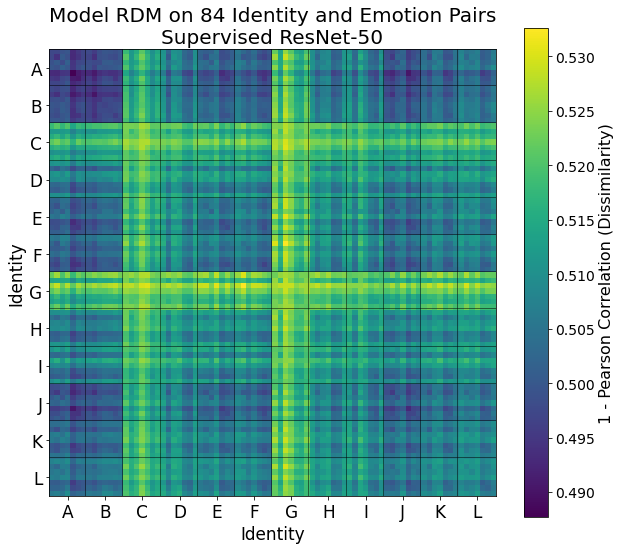

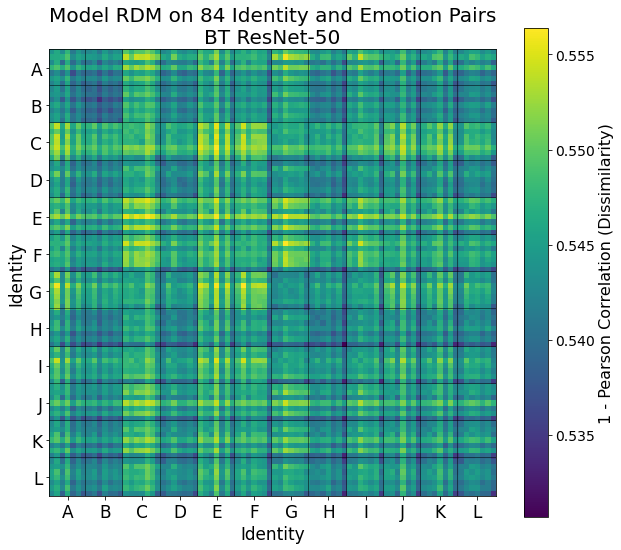

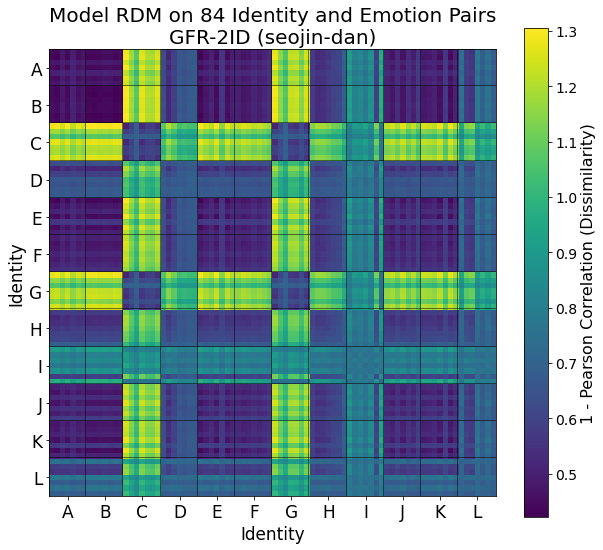

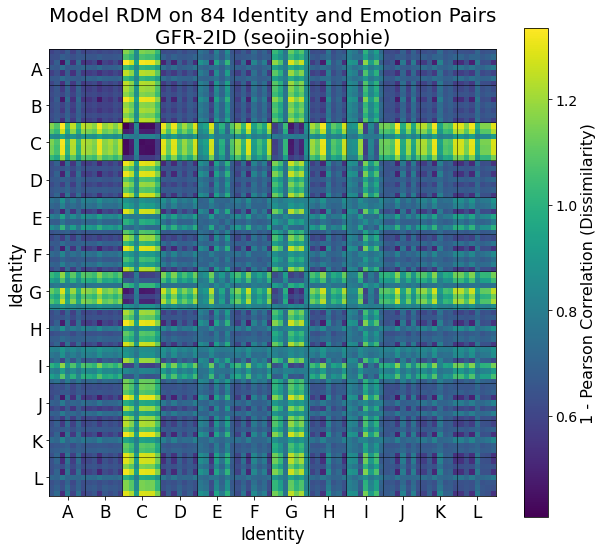

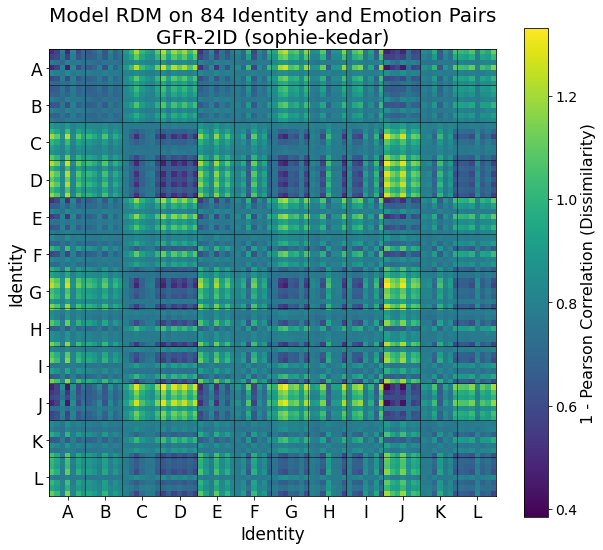

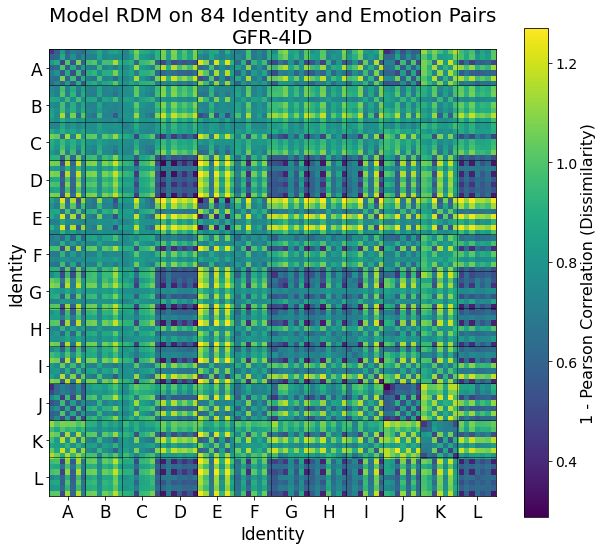

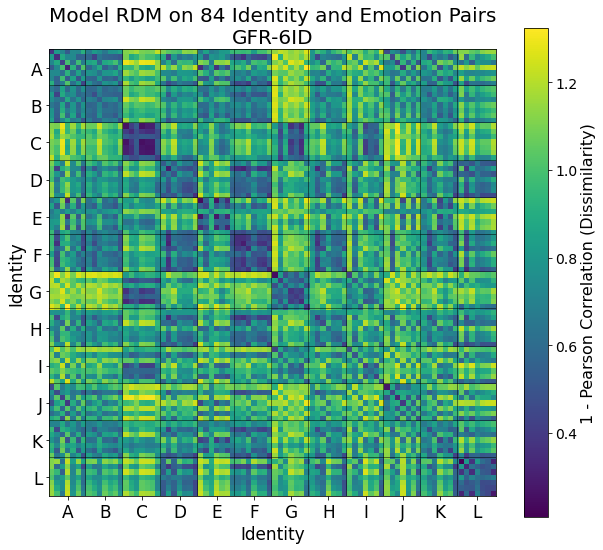

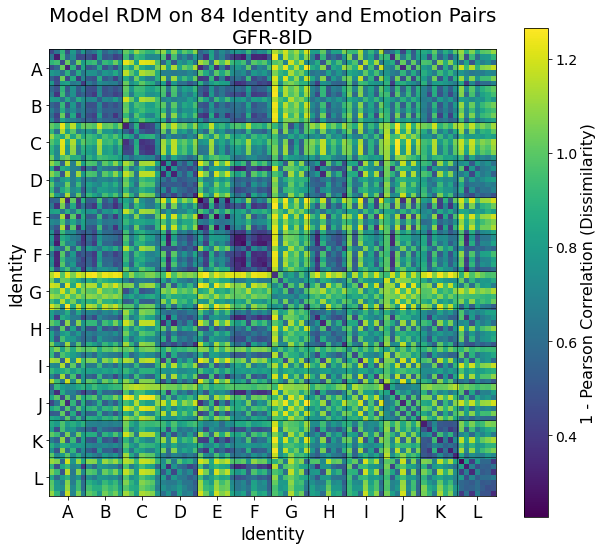

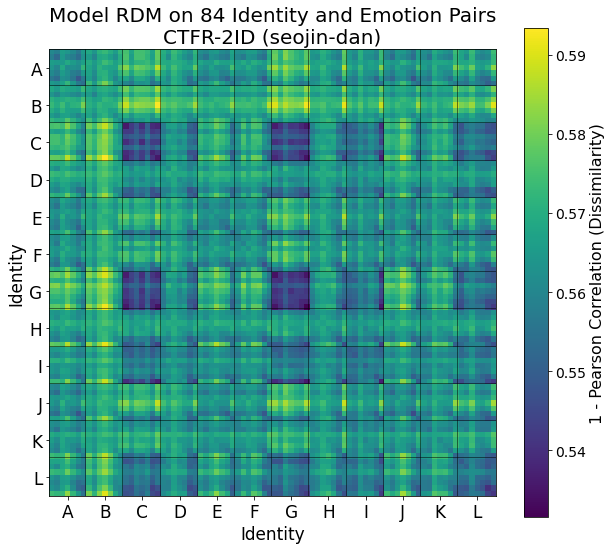

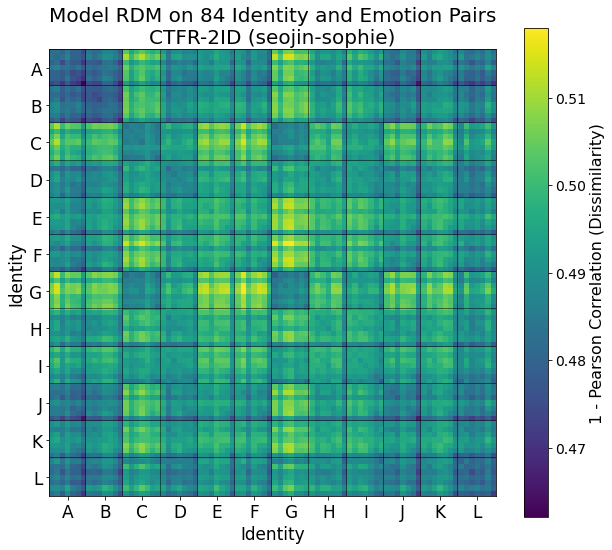

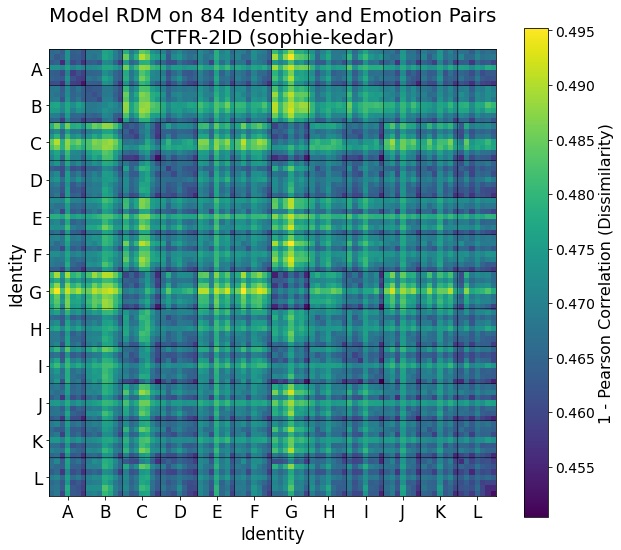

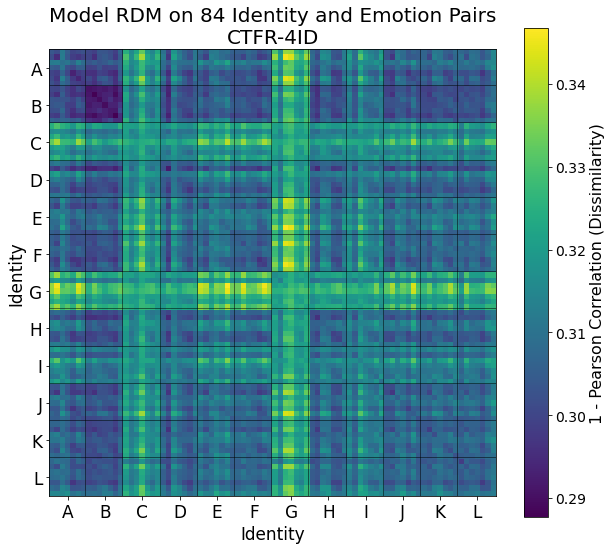

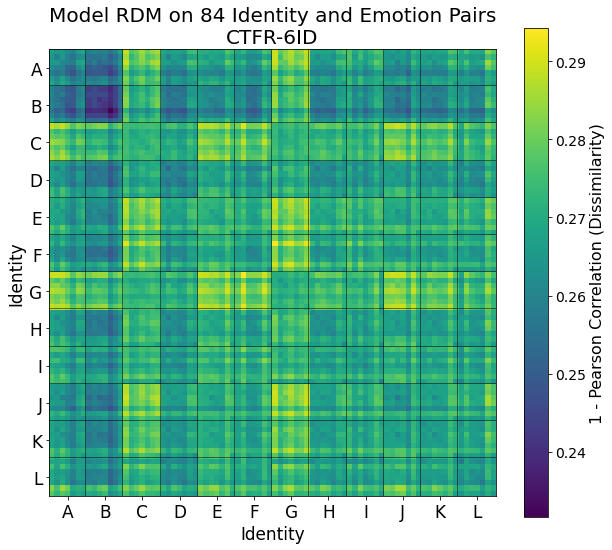

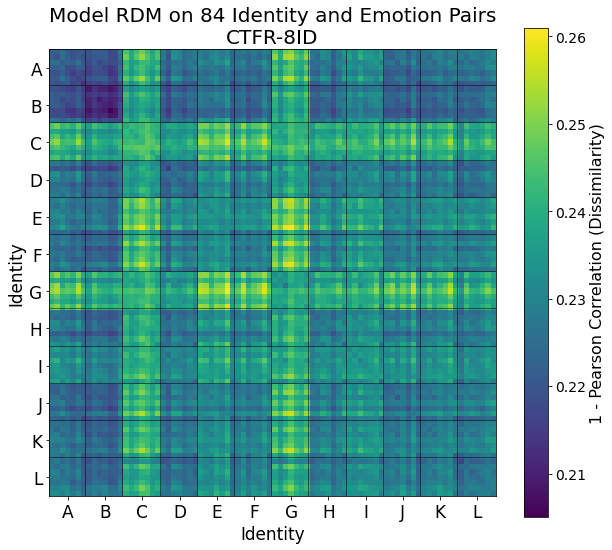

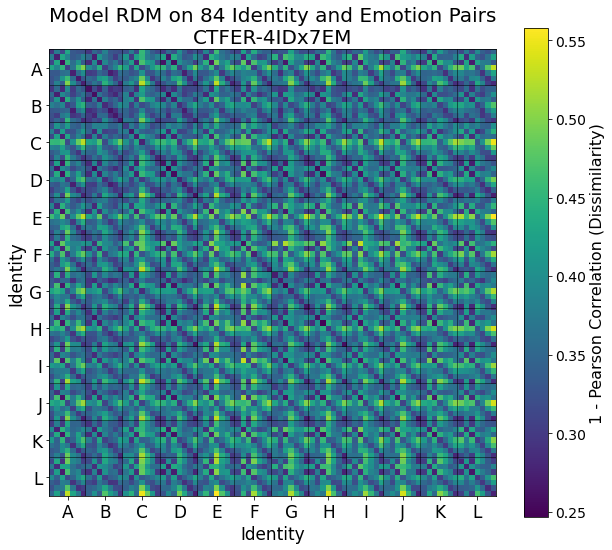

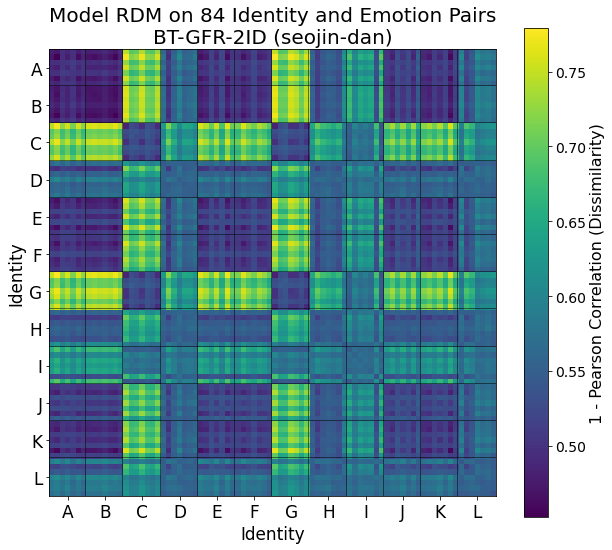

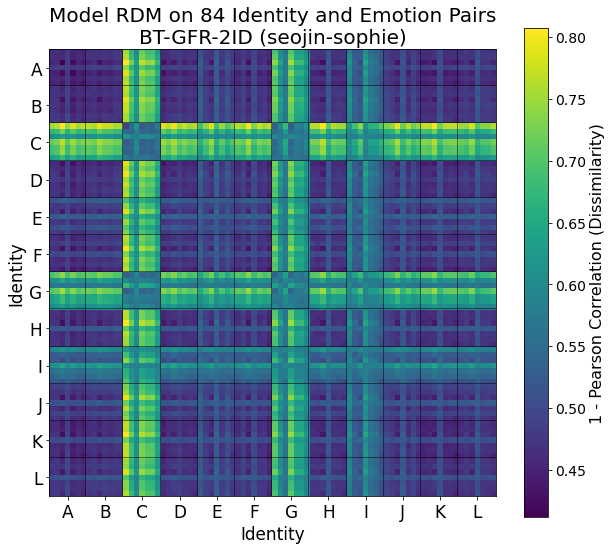

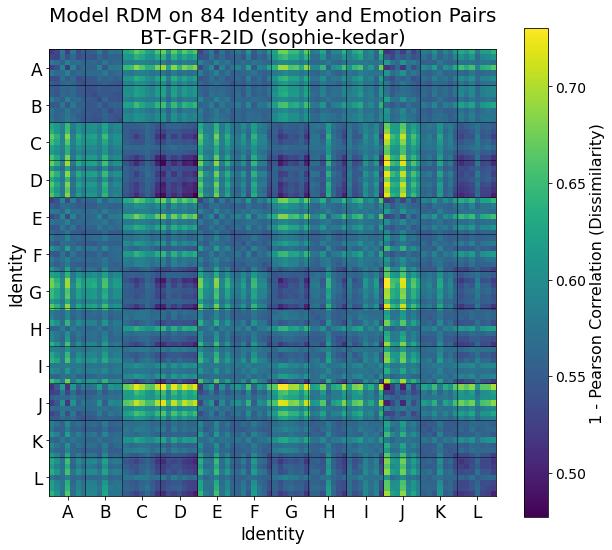

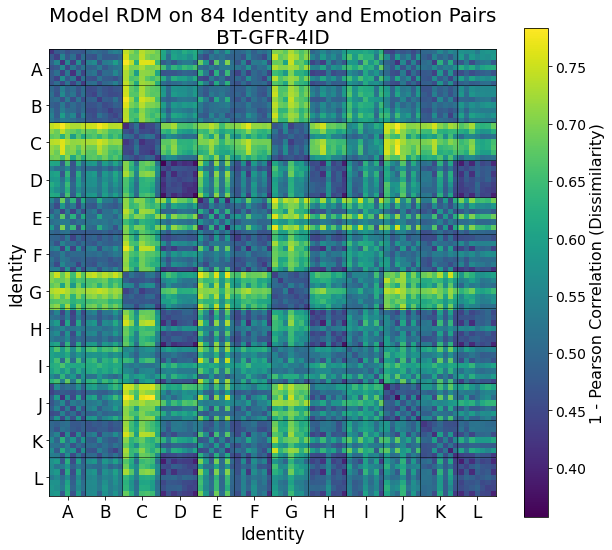

RDM file not found for model: off_the_shelf_barlowtwins_finetune_6way_final


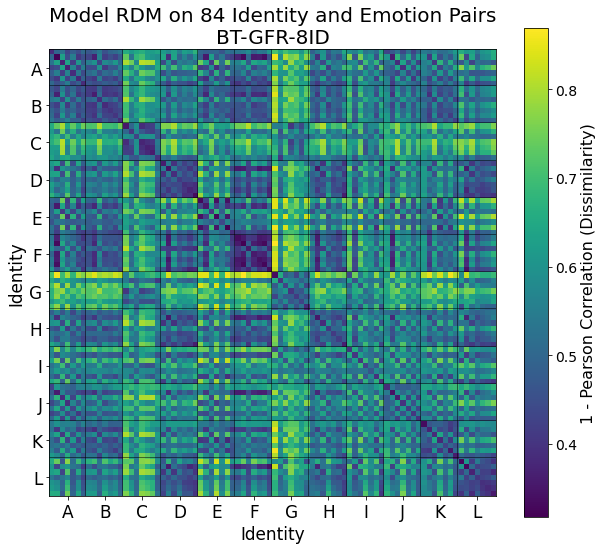

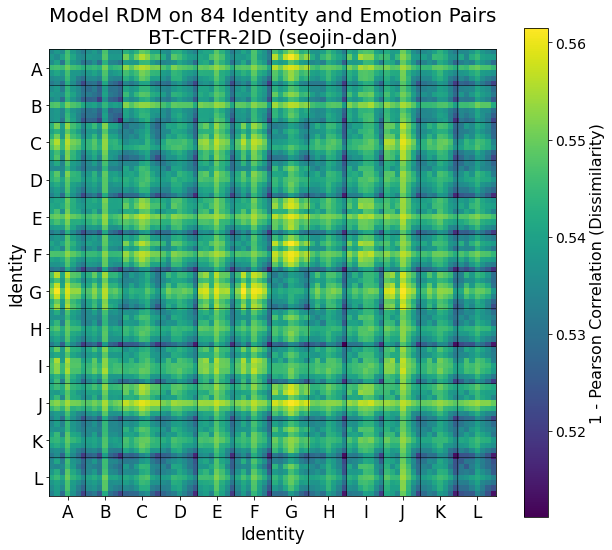

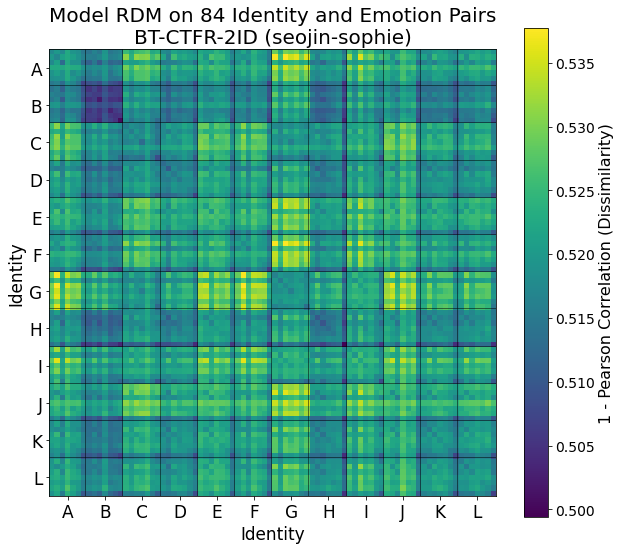

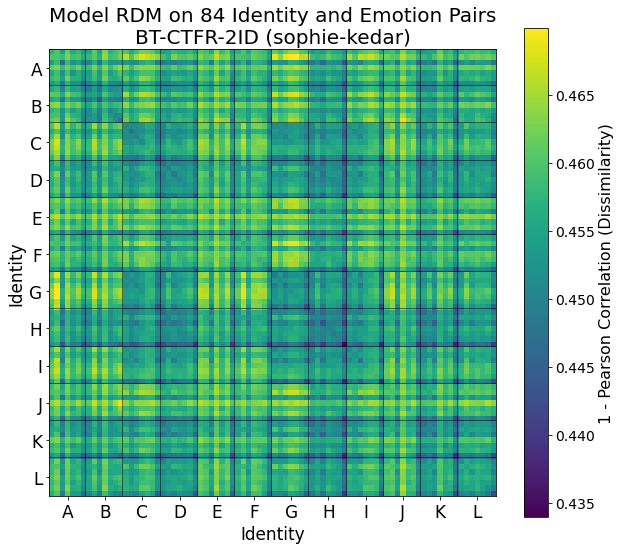

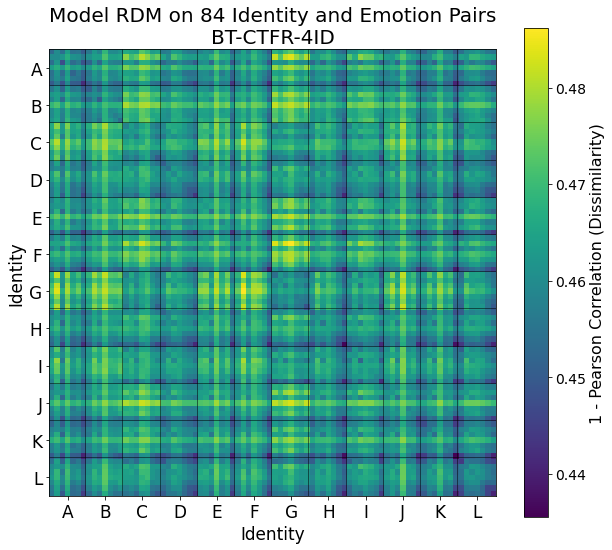

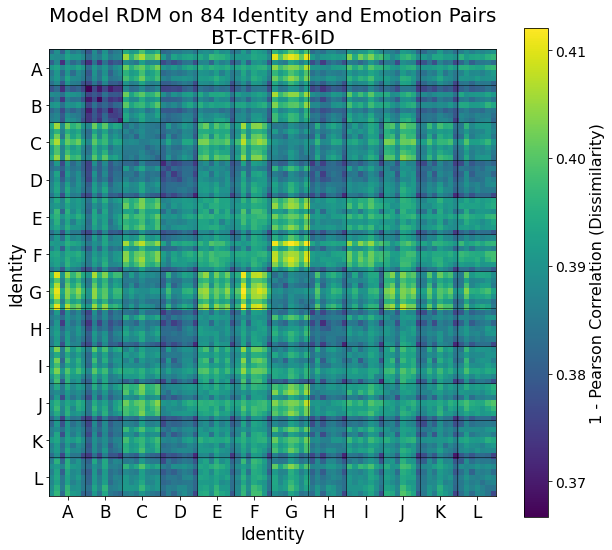

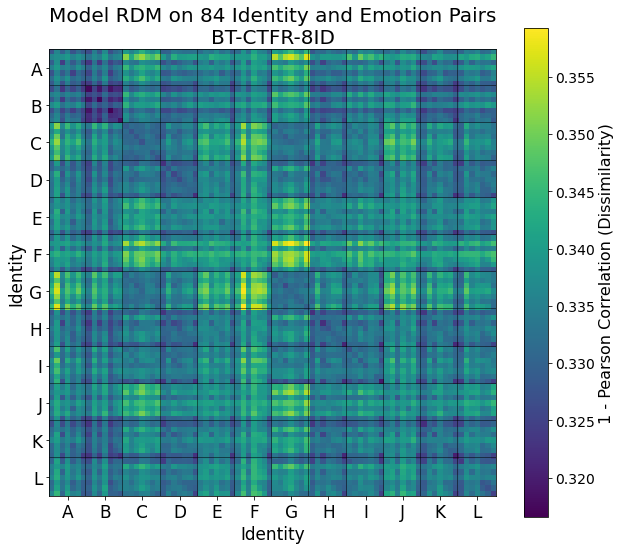

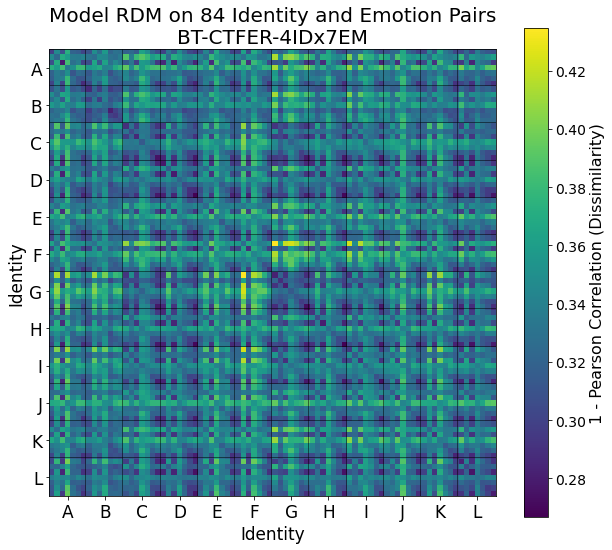

In [34]:
# plot block-averaged RDM

model_names_list = [
    'resnet50'
                    ]

model_names_list = [
    'resnet50',
    'barlowtwins',
    # GFR
    'SL_resnet50_finetune_vbsle_50k_seojin_dan_seed777_model_best_SL',
    'SL_resnet50_finetune_vbsle_50k_sophie_seojin_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_sophie_kedar_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_4way_KDAS_seed77_model_best',
    'SL_resnet50_finetune_vbsle_50k_6way_far_seed77_model_best',
    'SL_resnet50_finetune_vbsle_50k_8way_far_seed77_model_best',
    # CTFR
    'SL_resnet50_finetune_texture_colorbg_2way_seojin_dan_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_sophie_seojin_colorbg_seed777_model_best',
    'SL_resnet50_finetune_vbsle_50k_sophie_kedar_colorbg_seed777_model_best',
    'SL_resnet50_finetune_texture_colorbg_4way_seed77_model_best',
    'SL_resnet50_finetune_texture_colorbg_6way_seed77_model_best',
    'SL_resnet50_finetune_texture_colorbg_8way_seed77_model_best',
    # CTFER (28IDEM)
    'SL_resnet50_finetune_28way_IDEM_colorbg_seed777_model_best',
    # BT-GFR
    'off_the_shelf_barlowtwins_seojin_dan_epochs50',
    'off_the_shelf_barlowtwins_2way_seojin_sophie',
    'off_the_shelf_barlowtwins_2way_sophie_kedar',    
    'off_the_shelf_barlowtwins_finetune_4way_SSKD',
    'off_the_shelf_barlowtwins_finetune_6way_final',
    'off_the_shelf_barlowtwins_ID_8way_epochs50',

    # BT-CTFR
    'off_the_shelf_barlowtwins_texture_colorbg_2way_seojin_dan',
    'off_the_shelf_barlowtwins_texture_colorbg_2way_sophie_seojin',
    'off_the_shelf_barlowtwins_texture_colorbg_2way_sophie_kedar',
    'off_the_shelf_barlowtwins_texture_colorbg_4way',
    'off_the_shelf_barlowtwins_finetune_6way_final_colorbg',
    'off_the_shelf_barlowtwins_ID_8way_colorbg_epochs50',
    # BT-CTFER (28IDEM)
    'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50'
                    ]

print_names_list = [
    'Supervised ResNet-50',
    ]
print_names_list = [
    'Supervised ResNet-50',
    'BT ResNet-50',
    # GFR
    "GFR-2ID (seojin-dan)",
    "GFR-2ID (seojin-sophie)",
    "GFR-2ID (sophie-kedar)",
    "GFR-4ID", 
    "GFR-6ID",
    "GFR-8ID",
    # CTFR
    "CTFR-2ID (seojin-dan)",
    "CTFR-2ID (seojin-sophie)",
    "CTFR-2ID (sophie-kedar)",
    "CTFR-4ID", 
    "CTFR-6ID",
    "CTFR-8ID",
    # CTFER
    "CTFER-4IDx7EM",
    # BT-GFR
    "BT-GFR-2ID (seojin-dan)",
    "BT-GFR-2ID (seojin-sophie)",
    "BT-GFR-2ID (sophie-kedar)",
    "BT-GFR-4ID", 
    "BT-GFR-6ID",
    "BT-GFR-8ID",
    # BT-CTFR
    "BT-CTFR-2ID (seojin-dan)",
    "BT-CTFR-2ID (seojin-sophie)",
    "BT-CTFR-2ID (sophie-kedar)",
    "BT-CTFR-4ID", 
    "BT-CTFR-6ID",
    "BT-CTFR-8ID",
    # BT-CTFER
    "BT-CTFER-4IDx7EM",
    ]

identity_names = ['Elias', 'Neptune', 'Seojin', 'Sophie', 'Dan', 'Sreyas',
                  'Younah', 'Ashley', 'Josh', 'Kedar', 'Ani', 'Tony']

identities_print = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

emotion_names = ['neutral', 'happiness', 'surprise', 'sadness', 'disgust', 'anger', 'fear']

num_identities = len(identity_names)
num_emotions = len(emotion_names)
rdm_block_size = 50

# Plot loop
for j, model_name in enumerate(model_names_list):
    rdm_path = f"/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_full_20250528/combined_vbsl50_{model_name}_rdm_blockavg.npy"
    rdm_path = f"/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/correlation_analysis_updated/combined_vbsl50_{model_name}_rdm_blockavg.npy"
    rdm_path = f"/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_avgpool/combined_vbsl50_{model_name}_rdm_blockavg.npy"
    if not os.path.exists(rdm_path):
        print(f"RDM file not found for model: {model_name}")
        continue

    rdm = np.load(rdm_path)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Plot RDM
    im = ax.imshow(rdm, cmap="viridis", vmin=rdm.min(), vmax=rdm.max())
    ax.set_aspect('equal')
    cbar = plt.colorbar(im)
    cbar.set_label('1 - Pearson Correlation (Dissimilarity)', fontsize=16 )
    cbar.ax.tick_params(labelsize=14)

    # Title and axes
    ax.set_title(f'Model RDM on 84 Identity and Emotion Pairs\n{print_names_list[j]}', fontsize=20)
    ax.set_xlabel('Identity', fontsize=17)
    ax.set_ylabel('Identity', fontsize=17)
    
    # Identity tick lines and labels
    block_size = 7
    ticks = np.arange(0, num_identities * block_size, block_size)
    midpoints = ticks + (block_size / 2) - 0.5
    ax.set_xticks(midpoints)
    ax.set_yticks(midpoints)
    ax.set_xticklabels(identities_print,  fontsize=17)
    ax.set_yticklabels(identities_print, fontsize=17)
    
    # Grid lines
    for t in ticks[1:]:
        ax.axhline(t - 0.75, color='black', linewidth=0.5)
        ax.axvline(t - 0.75, color='black', linewidth=0.5)
    save_dir = "/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_figure_20250528"

    save_path = os.path.join(save_dir, f"{model_name}_rdm_blockavg.png")
    # plt.savefig(save_path)
    plt.savefig(f"rdm_{model_name}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

### Averaging across multiple models

In [ ]:
from collections import defaultdict

# average multiple models' RDMs (variants of the same model type)

def average_and_plot_rdms(model_names, save_dir, identity_names):
    # load RDMs for a  list of models, average, and plot/save the mean RDM.
    os.makedirs(save_dir, exist_ok=True)

    rdms = []
    for model in model_names:
        rdm_path = f"/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_full_20250528/combined_vbsl50_{model}_rdm_blockavg.npy"
        if os.path.exists(rdm_path):
            rdms.append(np.load(rdm_path))
        else:
            print(f"Missing RDM: {rdm_path}")

    avg_rdm = np.mean(np.stack(rdms), axis=0) # compute mean RDM
    np.save(os.path.join(save_dir, "mean_rdm.npy"), avg_rdm) # save averaged rdm

    # plot
    block_size = 7
    ticks = np.arange(0, len(identity_names) * block_size, block_size)
    mids = ticks + block_size / 2 - 0.5

    fig, ax = plt.subplots(figsize=(10, 9))
    im = ax.imshow(avg_rdm, cmap="viridis",
                   vmin=avg_rdm.min(), vmax=avg_rdm.max())
    cbar = plt.colorbar(im)
    cbar.set_label("1 − Pearson Correlation (Dissimilarity)", fontsize=14)

    ax.set_title("Mean RDM", fontsize=18)
    ax.set_xlabel("Identity", fontsize=14)
    ax.set_ylabel("Identity", fontsize=14)

    ax.set_xticks(mids)
    ax.set_yticks(mids)
    ax.set_xticklabels(identity_names, fontsize=12)
    ax.set_yticklabels(identity_names, fontsize=12)

    # draw grid lines to separate identity blocks
    for t in ticks:
        ax.axhline(t - 0.5, color="black", lw=0.5)
        ax.axvline(t - 0.5, color="black", lw=0.5)

    out_fig = os.path.join(save_dir, "mean_rdm_plot.png")
    plt.savefig(out_fig, bbox_inches="tight")
    plt.close()
    print(f"Saved averaged RDM to {out_fig}")

models_to_average = [
    "SL_resnet50_finetune_14way_IDEM_seojin_dan_colorbg_seed777_model_best",
    "SL_resnet50_finetune_14way_IDEM_seojin_sophie_colorbg_seed77_model_best",
    "SL_resnet50_finetune_14way_IDEM_sophie_kedar_colorbg_seed777_model_best",
]
identity_names = ["Elias","Neptune","Seojin","Sophie","Dan","Sreyas",
                  "Younah","Ashley","Josh","Kedar","Ani","Tony"]

average_and_plot_rdms(models_to_average,
                      "/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/figures_mean",
                      identity_names)


Saved averaged RDM to /mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/figures_mean/mean_rdm_plot.png


# Construct face space 

In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load .mat file
# scaledCoordMax_all_updated.mat contains the 3d coordinates data of each face category
mat = scipy.io.loadmat('scaledCoordsMax_all_updated.mat', struct_as_record=False, squeeze_me=True)
mat_struct = mat['scaledCoordsMax_all_updated']

/share/apps/anaconda3-2019.03/envs/DLC/lib/python3.7/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [ ]:
# build data matrix
original_identities = ['Elias', 'Neptune', 'Seojin', 'Sophie', 'Dan', 'Sreyas', 
                       'Younah', 'Ashley', 'Josh', 'Kedar', 'Ani', 'Tony']
anonymized_identities = [f'Identity {chr(65 + i)}' for i in range(len(original_identities))]
identity_map = dict(zip(original_identities, anonymized_identities))
emotions = ['neutral', 'happiness_4', 'surprise_4', 'sadness_4',
            'disgust_4', 'anger_4', 'fear_4']
num_faces = len(original_identities)
num_emotions = len(emotions)
num_vertices = 936

all_faces_data = np.zeros((num_faces * num_emotions, num_vertices * 3))
labels = []
counter = 0
for identity in original_identities:
    for emotion in emotions:
        key = f'{identity}_{emotion}'
        face = getattr(mat_struct, key)
        all_faces_data[counter, :] = face.reshape(-1)
        labels.append(identity)
        counter += 1

In [ ]:
# PCA
mean_face = all_faces_data.mean(axis=0)
centered = all_faces_data - mean_face
standardized = centered / np.std(centered, axis=0)
pca = PCA()
pca_coords = pca.fit_transform(standardized)

In [6]:
# Compute identity vector
identity_centroids = np.zeros((num_faces, pca_coords.shape[1]))
for i in range(num_faces):
    indices = np.arange(i * num_emotions, (i + 1) * num_emotions)
    identity_centroids[i, :] = np.mean(pca_coords[indices, :], axis=0)

cov_id = np.cov(identity_centroids.T)
evals_id, evecs_id = np.linalg.eigh(cov_id)
identity_vector = evecs_id[:, np.argmax(evals_id)]
identity_vector /= np.linalg.norm(identity_vector)

# Compute emotion vector
emotion_centroids = np.zeros((num_emotions, pca_coords.shape[1]))
for j in range(num_emotions):
    indices = np.arange(j, num_faces * num_emotions, num_emotions)
    emotion_centroids[j, :] = np.mean(pca_coords[indices, :], axis=0)

cov_em = np.cov(emotion_centroids.T)
evals_em, evecs_em = np.linalg.eigh(cov_em)
emotion_vector = evecs_em[:, np.argmax(evals_em)]
emotion_vector /= np.linalg.norm(emotion_vector)

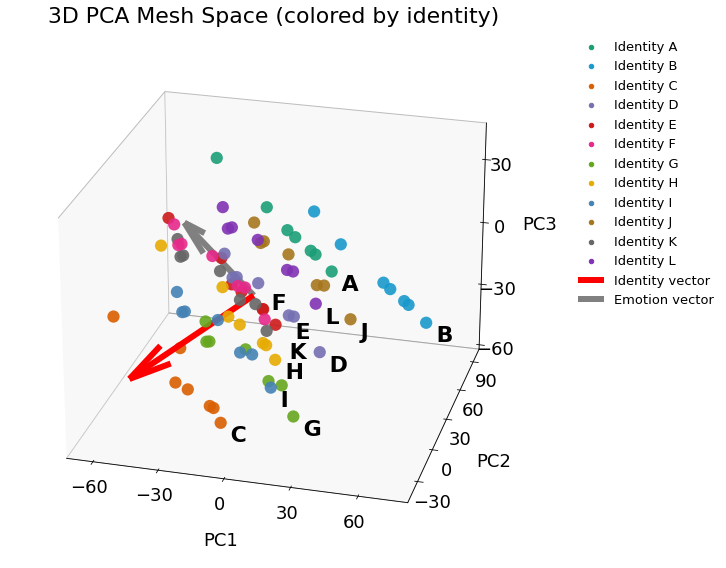

In [7]:
# View settings
elevations = [25]
azimuths = [-75]

for elev in elevations:
    for azim in azimuths:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Colors
        base_cmap = cm.get_cmap('Dark2', 12)
        identity_colors = [base_cmap(i) for i in range(num_faces)]
        identity_colors[4] = (0.8, 0.1, 0.1, 1.0)     # Dan (red)
        identity_colors[1] = (0.1, 0.6, 0.8, 1.0)     # Neptune (cyan)
        identity_colors[11] = (0.5, 0.2, 0.7, 1.0)    # Tony (purple)
        identity_colors[8] = (0.27, 0.51, 0.71, 1.0)  # Josh (orange)

        scatter_handles = []

        for i, identity in enumerate(original_identities):
            color = identity_colors[i]
            indices = [idx for idx, label in enumerate(labels) if label == identity]
            coords = pca_coords[indices]

            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                       color=color, s=150, depthshade=False, alpha=0.9,
                       edgecolors='none')

            scatter_handles.append(ax.scatter([], [], [], color=color, label=identity_map[identity]))

            # Pick endpoint for label placement
            pc1, pc2 = coords[:, 0], coords[:, 1]
            score = pc1 - 0.3 * pc2
            best_idx = indices[np.argmax(score)]

            # Custom offset cases
            if i == 5:
                offset = [-1, +3, +3]
            elif i == 4:
                offset = [+5, +3, -7]
            elif i == 10:
                offset = [+6, +3, -13]
            else:
                offset = [+2, -3, -7]

            ax.text(pca_coords[best_idx, 0] + offset[0],
                    pca_coords[best_idx, 1] + offset[1],
                    pca_coords[best_idx, 2] + offset[2],
                    identity_map[identity][8:], fontsize=22, weight='bold')

        # Vector plotting
        identity_vec_3d = identity_vector[:3] / np.linalg.norm(identity_vector[:3])
        emotion_vec_3d = emotion_vector[:3] / np.linalg.norm(emotion_vector[:3])
        origin = np.mean(pca_coords[:, :3], axis=0)
        scale = 65

        ax.quiver(*origin, *(identity_vec_3d * scale), color='red', linewidth=6,
                  arrow_length_ratio=0.3, label='Identity vector')
        ax.quiver(*origin, *(emotion_vec_3d * scale), color='gray', linewidth=6,
                  arrow_length_ratio=0.3, label='Emotion vector')

        # Axes settings
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('PC1', fontsize=18, labelpad=20)
        ax.set_ylabel('PC2', fontsize=18, labelpad=20)
        ax.set_zlabel('PC3', fontsize=18, labelpad=20)
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_yticks([-30, 0, 30, 60, 90])
        ax.set_zlim([-60, 45])
        ax.set_zticks([-60, -30, 0, 30])
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='z', which='major', labelsize=18)

        ax.set_title('3D PCA Mesh Space (colored by identity)', fontsize=22)
ax.grid(False)
ax.w_xaxis.pane.set_facecolor((0.95, 0.95, 0.95, 0.9))
ax.w_yaxis.pane.set_facecolor((0.95, 0.95, 0.95, 0.9))
ax.w_zaxis.pane.set_facecolor((0.95, 0.95, 0.95, 0.9))
ax.w_xaxis.pane.set_edgecolor('gray')
ax.w_yaxis.pane.set_edgecolor('gray')
ax.w_zaxis.pane.set_edgecolor('gray')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, frameon=False)
plt.tight_layout()
plt.show()

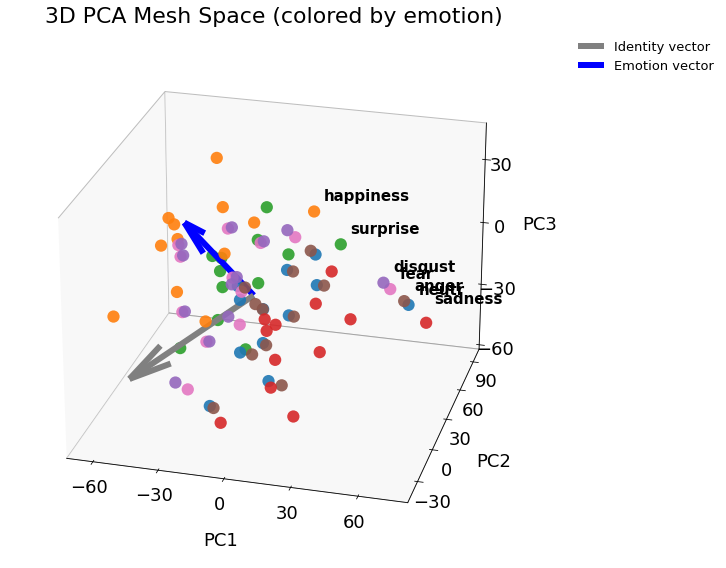

In [ ]:
# Assign emotion labels to each data point (same order as all_faces_data)
emotion_labels = emotions * num_faces  # ['neutral', 'happiness_4', ..., 'surprise_4', ...]
emotion_labels = [e for e in emotion_labels]  # flatten
emotion_to_color = {emotion: cm.get_cmap('tab10')(i) for i, emotion in enumerate(emotions)}


identity_centroids_full = np.zeros((num_faces, pca_coords.shape[1]))
for i in range(num_faces):
    indices = np.arange(i * num_emotions, (i + 1) * num_emotions)
    identity_centroids_full[i, :] = np.mean(pca_coords[indices, :], axis=0)

cov_id_full = np.cov(identity_centroids_full.T)
evals_id_full, evecs_id_full = np.linalg.eigh(cov_id_full)
identity_vector_full = evecs_id_full[:, np.argmax(evals_id_full)]
identity_vector_full /= np.linalg.norm(identity_vector_full)

emotion_centroids_full = np.zeros((num_emotions, pca_coords.shape[1]))
for j in range(num_emotions):
    indices = np.arange(j, num_faces * num_emotions, num_emotions)
    emotion_centroids_full[j, :] = np.mean(pca_coords[indices, :], axis=0)

cov_em_full = np.cov(emotion_centroids_full.T)
evals_em_full, evecs_em_full = np.linalg.eigh(cov_em_full)
emotion_vector_full = evecs_em_full[:, np.argmax(evals_em_full)]
emotion_vector_full /= np.linalg.norm(emotion_vector_full)


# Example: vary elevation from 10 to 30 degrees while keeping azim fixed
# Try a few combinations of elevation and azimuth
# elevations = [10, 15, 20, 25, 30, 35]     # Up-down tilt
# azimuths = [-85, -80, -75, -70]    # Left-right spin
# azimuths = [-35, -30, -25, -10]    # Left-right spin
elevations = [25]     # Up-down tilt
azimuths = [-75]    # Left-right spin
for elev in elevations:
    for azim in azimuths:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter_handles = []  # Reset here to avoid duplicates in legend

        base_cmap = cm.get_cmap('Dark2', 12)
        identity_colors = [base_cmap(i) for i in range(num_faces)]

        identity_colors[4] = (0.8, 0.1, 0.1, 1.0)  # red
        identity_colors[1] = (0.1, 0.6, 0.8, 1.0)  # cyan
        identity_colors[11] = (0.5, 0.2, 0.7, 1.0)  # purple
        identity_colors[8] = (0.27, 0.51, 0.71, 1.0)  # orange

        # Plot each emotion separately
        scatter_handles = []
        for j, emotion in enumerate(emotions):
            color = emotion_to_color[emotion]
            indices = [idx for idx, label in enumerate(emotion_labels) if label == emotion]
            coords = pca_coords[indices]
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                       color=color, s=150, depthshade=False, alpha=0.9,
                       edgecolors='none')
            # scatter_handles.append(ax.scatter([], [], [], color=color, label=emotion))

            # Find endpoint for labeling
            pc1 = coords[:, 0]
            pc2 = coords[:, 1]
            score = pc1 
            best_idx = indices[np.argmax(score)]
            
            if j == 3:
                ax.text(pca_coords[best_idx, 0] +4,
                        pca_coords[best_idx, 1] -3  ,
                        pca_coords[best_idx, 2] +11,
                        emotion[:-2],
                        fontsize=15, weight='bold')
            # elif j == 4:
            #     ax.text(pca_coords[best_idx, 0] +7,
            #             pca_coords[best_idx, 1] -3  ,
            #             pca_coords[best_idx, 2] + 6,
            #             emotion[:-2],
            #             fontsize=15, weight='bold')
            # elif j == 5:
            #     ax.text(pca_coords[best_idx, 0] +4,
            #             pca_coords[best_idx, 1] -3  ,
            #             pca_coords[best_idx, 2] + 3,
            #             emotion[:-2],
            #             fontsize=15, weight='bold')
            # elif j == 0:
            #     ax.text(pca_coords[best_idx, 0] +10,
            #             pca_coords[best_idx, 1] -3  ,
            #             pca_coords[best_idx, 2]-2 ,
            #             emotion,
            #             fontsize=15, weight='bold')
            # elif j == 2:
            #     ax.text(pca_coords[best_idx, 0] +5,
            #             pca_coords[best_idx, 1] -3  ,
            #             pca_coords[best_idx, 2] -3,
            #             emotion[:-2],
            #             fontsize=15, weight='bold')
            else :
                ax.text(pca_coords[best_idx, 0] +5,
                        pca_coords[best_idx, 1] -3  ,
                        pca_coords[best_idx, 2] + 7,
                        emotion[:-2],
                        fontsize=15, weight='bold')

        ax.view_init(elev=elev, azim=azim)
                # Project full-dimensional vectors onto 3D PCA space
        identity_vec_3d = identity_vector_full[:3]
        emotion_vec_3d = emotion_vector_full[:3]
        identity_vec_3d /= np.linalg.norm(identity_vec_3d)
        emotion_vec_3d /= np.linalg.norm(emotion_vec_3d)
        # Plot from origin
        origin = np.mean(pca_coords[:, :3], axis=0)
        scale = 65

        ax.quiver(*origin, *(identity_vec_3d * scale), color='gray', linewidth=6,
                arrow_length_ratio=0.3, label='Identity vector')
        ax.quiver(*origin, *(emotion_vec_3d * scale), color='blue', linewidth=6,
                arrow_length_ratio=0.3, label='Emotion vector')

        
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('PC1', fontsize=18, labelpad=20)
        ax.set_ylabel('PC2', fontsize=18, labelpad=20)
        ax.set_zlabel('PC3', fontsize=18, labelpad=20)
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_yticks([-30, 0, 30, 60, 90])
        ax.set_zlim([-60, 45])
        ax.set_zticks([-60, -30, 0, 30])
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='z', which='major', labelsize=18)
        ax.set_title(f'3D PCA Mesh Space (colored by emotion)', fontsize=22)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, frameon=False)
ax.grid(False)
ax.w_xaxis.pane.set_facecolor((0.95, 0.95, 0.95, 0.9))
ax.w_yaxis.pane.set_facecolor((0.95, 0.95, 0.95, 0.9))
ax.w_zaxis.pane.set_facecolor((0.95, 0.95, 0.95, 0.9))
ax.w_xaxis.pane.set_edgecolor('gray')
ax.w_yaxis.pane.set_edgecolor('gray')
ax.w_zaxis.pane.set_edgecolor('gray')
plt.tight_layout()
plt.show()
        

# Compute ground-truth face space distance matrix

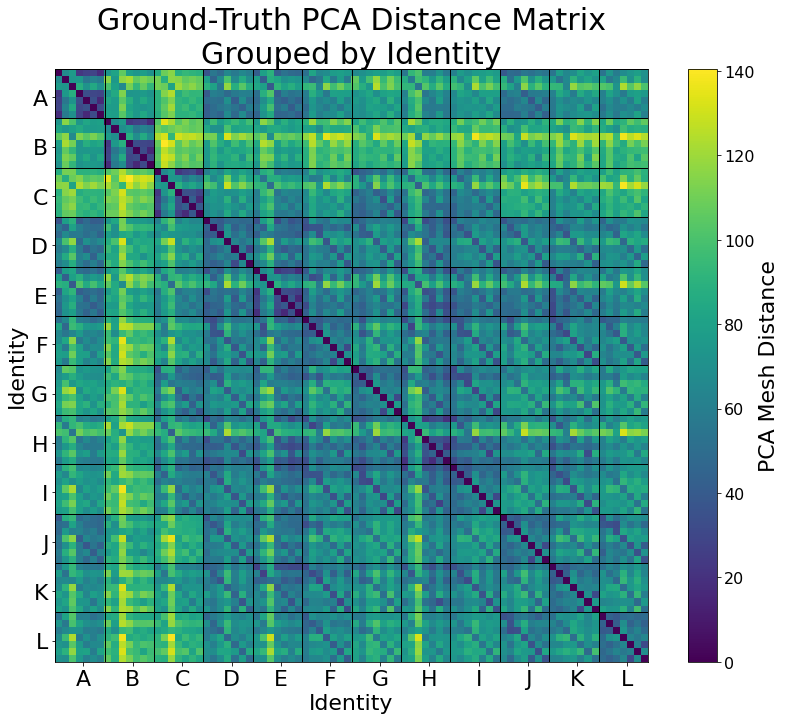

In [ ]:
# Ground truth 84x84 mesh distance matrix
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load the distance matrix
mat = loadmat('/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50/pca_distance_matrix_full_updated.mat')
pca_dist = mat['pca_distance_matrix_full']  # Shape (84, 84)

# Emotion and identity info
identities = ['Elias', 'Neptune', 'Seojin', 'Sophie', 'Dan', 'Sreyas',
              'Younah', 'Ashley', 'Josh', 'Kedar', 'Ani', 'Tony']
identities = ['A', 'B', 'C', 'D', 'E', 'F',
              'G', 'H', 'I', 'J', 'K', 'L']
emotions = ['neutral', 'happiness_4', 'surprise_4', 'sadness_4',
            'disgust_4', 'anger_4', 'fear_4']
# emotions = ['neutral', 'happiness_4', 'sadness_4', 'disgust_4',
#             'fear_4', 'anger_4', 'surprise_4']

# Compute ticks
tick_positions = np.arange(3.5, 84, 7)  # center of each identity block
section_bounds = np.arange(0, 85, 7)    # boundaries for emotion groups

# Plot
plt.figure(figsize=(12, 10))
im = plt.imshow(pca_dist, cmap='viridis', vmin=0, vmax=140.47162419308918)
cbar = plt.colorbar(im)
cbar.set_label('PCA Mesh Distance', fontsize=22)
cbar.ax.tick_params(labelsize=16)
plt.title('Ground-Truth PCA Distance Matrix\nGrouped by Identity', fontsize=30)
plt.xlabel('Identity', fontsize=22)
plt.ylabel('Identity', fontsize=22)

# Set identity ticks
plt.xticks(tick_positions, identities, fontsize=22)
plt.yticks(tick_positions, identities, fontsize=22)

# Add boundary lines to separate emotion groups
for b in section_bounds:
    plt.axhline(b - 0.5, color='k', linewidth=1.)
    plt.axvline(b - 0.5, color='k', linewidth=1.)

# plt.axis('square')
plt.tight_layout()
plt.show()


### Compute RDM-distance matrix corr (model-face space)

In [11]:
# compute corr
# For full frontal face images 

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.spatial.distance import cosine, euclidean
from scipy.spatial import procrustes
import numpy as np

model_names_list = ['resnet50']

mat = loadmat('/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50/pca_distance_matrix_full.mat')
pca_dist = mat['pca_distance_matrix_full']  # This will be a NumPy array
triu_idx = np.triu_indices(pca_dist.shape[0], k=1)
pca_flat = pca_dist[triu_idx]

for model_name in model_names_list :
    rdm_dist = np.load(f'/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_full_20250528/combined_vbsl50_{model_name}_rdm_blockavg.npy')
    # rdm_dist = np.load(f'/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_figure_20250528/avg_rdm_CTFER-14IDEM.npy')

    rdm_flat = rdm_dist[triu_idx]
    spearman_rho, _ = spearmanr(rdm_flat, pca_flat)
    print(model_name)
    print(spearman_rho)

resnet50
0.10704835408927019


# Identity-only analysis (n=12)

### Collapse original RDM to identity-only

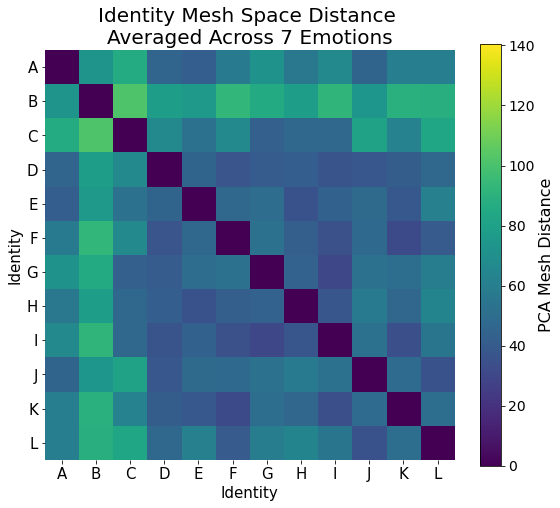

In [12]:
# Block-averaged Identity mesh distance
identity_dist_avg_BLOCKAVG = np.zeros((12, 12))

# For each emotion index (7 total)
for j in range(7):
    indices = [i * 7 + j for i in range(12)]  # All 12 identities with emotion j
    submatrix = pca_dist[np.ix_(indices, indices)]
    identity_dist_avg_BLOCKAVG += submatrix

# Average across 7 emotions
identity_dist_avg_BLOCKAVG /= 7
plt.figure(figsize=(8, 7))
im = plt.imshow(identity_dist_avg_BLOCKAVG, cmap='viridis', vmin=0, vmax=140.47162419308918)
cbar = plt.colorbar(im)
cbar.set_label('PCA Mesh Distance',  fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.title('Identity Mesh Space Distance \nAveraged Across 7 Emotions', fontsize=20)
plt.xticks(np.arange(12), identities, rotation=0, fontsize=15)
plt.yticks(np.arange(12), identities, fontsize=15)
plt.xlabel('Identity', fontsize=15)
plt.ylabel('Identity', fontsize=15)
# Overlay values
# for i in range(12):
#     for j in range(12):
#         plt.text(j, i, f'{identity_dist_avg_BLOCKAVG[i, j]:.0f}', ha='center', va='center', color='black', fontsize=12)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()
# plt.savefig("fig7D_side.pdf", format="pdf", bbox_inches="tight")

# np.save('identity_dist_avg.npy', identity_dist_avg_BLOCKAVG)



### Collapse original distance matrix to identity-only

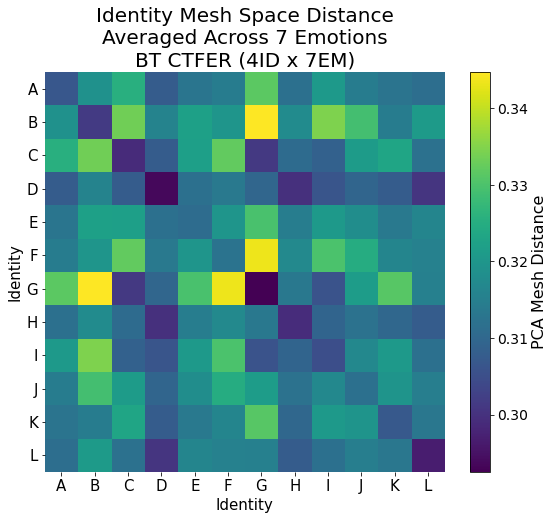

In [14]:
# Block-averaged Emotion mesh distance comeback
mat = loadmat('/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50/pca_distance_matrix_full.mat')
pca_dist = mat['pca_distance_matrix_full']  # Shape (84, 84)
model_name = 'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50'
print_name = 'BT CTFER (4ID x 7EM)'
rdm_path = f"/mnt/smb/locker/issa-locker/users/Seojin/data/face_data/vbsl50_registered/vbsl50_registered_full_20250528/combined_vbsl50_{model_name}_rdm_blockavg.npy"
rdm = np.load(rdm_path)
pca_dist = rdm
# Initialize accumulator
emotion_identity_matrices = []

for j in range(7):
    indices = [i * 7 + j for i in range(12)]
    identity_matrix = pca_dist[np.ix_(indices, indices)]
    emotion_identity_matrices.append(identity_matrix)
identity_dist_avg_BLOCKAVG = np.mean(emotion_identity_matrices, axis=0)

plt.figure(figsize=(8, 7))
im = plt.imshow(identity_dist_avg_BLOCKAVG, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('PCA Mesh Distance', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.title(f'Identity Mesh Space Distance\nAveraged Across 7 Emotions\n{print_name}', fontsize=20)
plt.xticks(np.arange(12), identities, rotation=0, fontsize=15)
plt.yticks(np.arange(12), identities, fontsize=15)
plt.xlabel('Identity', fontsize=15)
plt.ylabel('Identity', fontsize=15)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()



# Emotion-only analysis (n=7)

### Collapse original RDM to emotion-only

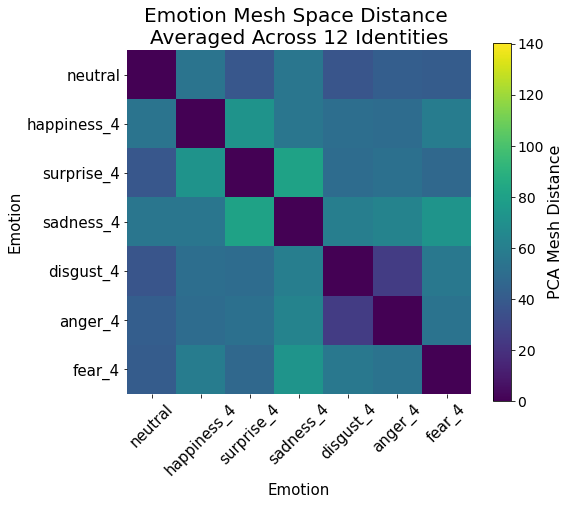

In [13]:
# Block-averaged Emotion mesh distance
emotion_dist_avg_BLOCKAVG = np.zeros((7, 7))

# For each identity index (12 total)
for i in range(12):
    indices = [i * 7 + j for j in range(7)]  # All 7 emotions for identity i
    submatrix = pca_dist[np.ix_(indices, indices)]
    emotion_dist_avg_BLOCKAVG += submatrix

# Average across 12 identities
emotion_dist_avg_BLOCKAVG /= 12

# Plot
plt.figure(figsize=(8, 7))
im = plt.imshow(emotion_dist_avg_BLOCKAVG, cmap='viridis', vmin=0, vmax=140.47162419308918)
cbar = plt.colorbar(im)
cbar.set_label('PCA Mesh Distance', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.title('Emotion Mesh Space Distance \nAveraged Across 12 Identities', fontsize=20)
plt.xticks(np.arange(7), emotions, rotation=45, fontsize=15)
plt.yticks(np.arange(7), emotions, fontsize=15)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Emotion', fontsize=15)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
# plt.savefig("fig7D_emotion_BLOCKAVG.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Save if needed
# np.save('emotion_dist_avg_updated_ver2.npy', emotion_dist_avg_BLOCKAVG)


### Collapse original distance matrix to emotion-only

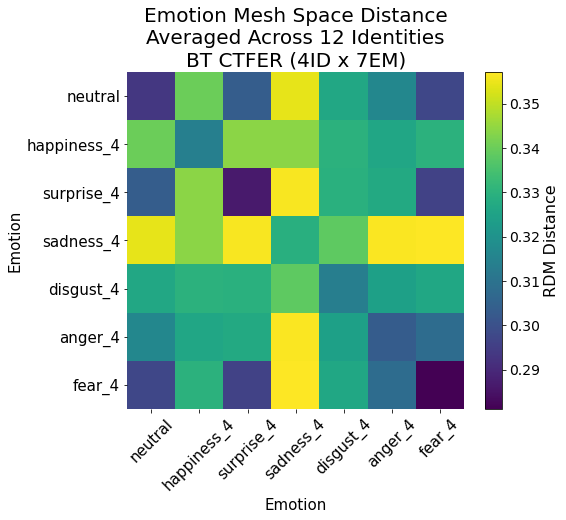

In [ ]:
identity_emotion_matrices = []

for i in range(12):
    start = i * 7
    end = start + 7
    emotion_matrix = pca_dist[start:end, start:end]
    identity_emotion_matrices.append(emotion_matrix)

emotion_dist_avg_BLOCKAVG = np.mean(identity_emotion_matrices, axis=0)
plt.figure(figsize=(8, 7))
im = plt.imshow(emotion_dist_avg_BLOCKAVG, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('RDM Distance', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.title(f'Emotion Mesh Space Distance\nAveraged Across 12 Identities\n{print_name}', fontsize=20)
plt.xticks(np.arange(7), emotions, rotation=45, ha='center', fontsize=15)
plt.yticks(np.arange(7), emotions, fontsize=15)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Emotion', fontsize=15)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()